# Предсказание стоимости жилья

<h1>Содержание:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-и-предобработка-данных" data-toc-modified-id="Анализ-и-предобработка-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Анализ и предобработка данных</a></span></li><li><span><a href="#Подготовка-данных-для-обучения-модели" data-toc-modified-id="Подготовка-данных-для-обучения-модели-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подготовка данных для обучения модели</a></span><ul class="toc-item"><li><span><a href="#Преобразование-категориальных-признаков" data-toc-modified-id="Преобразование-категориальных-признаков-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Преобразование категориальных признаков</a></span></li><li><span><a href="#Преобразование-числовых-признаков" data-toc-modified-id="Преобразование-числовых-признаков-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Преобразование числовых признаков</a></span></li><li><span><a href="#Преобразование-категориальных-и-численных-признаков-в-один-вектор" data-toc-modified-id="Преобразование-категориальных-и-численных-признаков-в-один-вектор-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Преобразование категориальных и численных признаков в один вектор</a></span></li><li><span><a href="#Разбивка-данных-на-выборки" data-toc-modified-id="Разбивка-данных-на-выборки-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Разбивка данных на выборки</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></div>

## Описание проекта

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. 

В данных представлены следующие признаки:
- longitude — широта;
- latitude — долгота;
- housing_median_age — медианный возраст домов в жилом массиве;
- total_rooms — общее количество комнат в домах жилого массива;
- total_bedrooms — общее количество спален в домах жилого массива;
- population — количество человек, которые проживают в жилом массиве;
- households — количество домовладений в жилом массиве;
- median_income — медианный доход жителей жилого массива;
- median_house_value — медианная стоимость дома в жилом массиве;
- ocean_proximity — близость к океану.

Будут обучены две модели линейной регрессии на разных наборах данных:

- используя все данные (числовые и категориальные переменные) из файла;
- используя только числовые переменные, исключив категориальные.

Для построения модели будет использован оценщик `LinearRegression` из библиотеки **`MLlib`**. Результаты работы линейной регрессии на двух наборах данных будут сравниваться по метрикам `RMSE`, `MAE` и `R2`.

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd 
import numpy as np
import seaborn as sns

# импорт pyspark библиотек
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# проверяем версию pyspark и подгружаем соответсвующий OHE
pyspark_version = pyspark.__version__
print('Версия Pyspark', pyspark_version)
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

Версия Pyspark 3.0.2


In [2]:
# зададим константу для псевдослучайного состояния
RAND_ST = 777

In [3]:
# инициализируем сессию Pyspark
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California Housing") \
                    .getOrCreate()

### Загрузка данных

In [5]:
# считываем данные в df
df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True)
# выведем информацию о схеме
df.printSchema()
df.show(10)
# df.take(15)[0].asDict()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

In [21]:
# кэшируем DF и создаем Table view of DataFrame для Spark SQL
df.cache
df.createOrReplaceTempView('housing')
spark.catalog.cacheTable('housing')

23/03/24 08:37:00 WARN CacheManager: Asked to cache already cached data.


Все признаки, кроме `'ocean_proximity'` имеют *вещественный* тип данных (или *float*). `'ocean_proximity'` - *строковый* тип данных (или *object*).

### Анализ и предобработка данных

In [5]:
# проверим данные на наличие пропусков
def get_null_in_collumns(dataframe):
    res = ''
    for col in dataframe.columns:
        na_percent = dataframe.filter(F.isnan(col) | dataframe[col].isNull()).count() / dataframe.count() * 100
        res += f'{col} {dataframe.filter(F.isnan(col) | dataframe[col].isNull()).count()} {round(na_percent)}%\n'
    return res


print(get_null_in_collumns(df))

longitude 0 0%
latitude 0 0%
housing_median_age 0 0%
total_rooms 0 0%
total_bedrooms 207 1%
population 0 0%
households 0 0%
median_income 0 0%
median_house_value 0 0%
ocean_proximity 0 0%



В колонке `'total_bedrooms'` есть 207 пропусков значений. Так как пропусков только **1%** предлагается заполнить их медианным значением, подсчитаанным по всей колонке `'total_bedrooms'`.

In [6]:
# найдем медианное значение по колонке total_bedrooms
tot_bedrooms_median = df.approxQuantile('total_bedrooms', [0.5], 0)[0]
# заполним пропуски медианным значением
df = df.fillna(tot_bedrooms_median, subset=['total_bedrooms'])
# проверим данные на пропуски после заполнения медианой
print(get_null_in_collumns(df))

longitude 0 0%
latitude 0 0%
housing_median_age 0 0%
total_rooms 0 0%
total_bedrooms 0 0%
population 0 0%
households 0 0%
median_income 0 0%
median_house_value 0 0%
ocean_proximity 0 0%



In [7]:
# посмотрим на статистики данных
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20640,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,536.8388565891473,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,419.39187792168866,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Исходя из описания признаков и их логического содержания можно выделить следующие особенности в данных:
- отрицательные значения признаков, кроме `'longitude'` отсутствуют;
- существуют жилые массивы, в которых `общее количество комнат` всего `2`;
- существуют жилые массивы, в которых `общее количество спален` всего `1`;
- существуют жилые массивы, в которых `проживает` всего `3 человека`;
- существуют жилые массивы, в которых `расположен` всего `1 дом`.

Уверенно сказать, что такие данные являются выбросами нельзя, так как возможно такие жилые массивы представляют собой одиночные дома в частном секторе с большой площадью.

23/03/22 14:14:43 WARN Executor: Managed memory leak detected; size = 5244504 bytes, TID = 128
23/03/22 14:14:45 WARN Executor: Managed memory leak detected; size = 5244504 bytes, TID = 130
23/03/22 14:14:46 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/22 14:14:46 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


<AxesSubplot:>

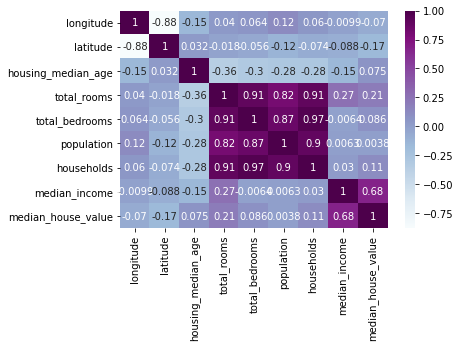

In [8]:
# определим список количестенных признаков
num_cols = [c for c in df.columns if c != 'ocean_proximity']

# определим список категориальных признаков
cat_cols = ['ocean_proximity']

# преобразуем данные в вектор
vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=num_cols, outputCol=vector_col)
df_vector = assembler.transform(df[num_cols])

# создаем матрицу корреляции с коэфициентом Спирмена
matrix = Correlation.corr(df_vector, vector_col, 'spearman')
cor_matrix = matrix.collect()[0][matrix.columns[0]].toArray()
matrix_df = pd.DataFrame(cor_matrix, columns=num_cols)
matrix_df.index = num_cols

# выведем график корреляции в виде heatmap диаграммы
sns.heatmap(matrix_df, annot=True, cmap="BuPu")

Из матрицы корреляции следует:
- с целевым признаком `'median_house_value'` сильно коррелирует признак `'median_income'`, что может хорошо отразится на предсказательной способности модели. Медианный доход жителей жилого массива положительно коррелирует со стоимостью их жилья;
- существует сильная корреляция между следующими признаками: `'total_bedrooms'`, `'population'`, `'households'` и `'total_rooms'`.

### Подготовка данных для обучения модели

Подготовим все шаги преобразований категориальных и числовых данных с использованием `Pipeline`.

#### Преобразование категориальных признаков

Трансформируем категориальный признак `'ocean_proximity'` с помощью `StringIndexer`.

In [9]:
indexer = StringIndexer(inputCols=cat_cols, 
                        outputCols=[c+'_idx' for c in cat_cols]) 
# df = indexer.fit(df).transform(df)
# cols = [c for c in df.columns for i in cat_cols if (c.startswith(i))]
# df.select(cols).show(5) 

Дополнительно проведем OHE-кодирование для категориального признака `'ocean_proximity'`.

In [10]:
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in cat_cols],
                        outputCols=[c+'_ohe' for c in cat_cols])
# df = encoder.fit(df).transform(df)
# cols = [c for c in df.columns for i in cat_cols if c.startswith(i)]
# df.select(cols).show(5)

Объединим преобразованные признаки в один вектор, с помощью `VectorAssembler`.

In [11]:
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in cat_cols],
                                        outputCol="categorical_features")
# df = categorical_assembler.transform(df)

#### Преобразование числовых признаков

Так как линейные модели чувствительны к масштабу значений признаков, трансформируем числовые признаки с помощью `StandardScaler`.

Для начала необходимо исключить целевой признак `'median_house_value'` из числовых данных, а так же создать переменную, которая будет хранить название этого целевого признака.

In [12]:
# исключаем целевой признак из данных
num_cols = [c for c in num_cols if c != 'median_house_value']
# создаем переменную для таргета
target = 'median_house_value'

In [13]:
# создаем вектор
numerical_assembler = VectorAssembler(inputCols=num_cols, outputCol="numerical_features")
# df = numerical_assembler.transform(df)
# приводим значения к одному масштабу
standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
# df = standardScaler.fit(df).transform(df)

#### Преобразование категориальных и численных признаков в один вектор

In [14]:
all_features = ['categorical_features','numerical_features_scaled']
final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="all_features") 
# df = final_assembler.transform(df)
# df.select(all_features).show(5) 

#### Разбивка данных на выборки

Разделим данные на две выбокри: `train` и `test` в соотношении 3 к 1.

In [15]:
# делим выборки на обучающую и тестовую
train_data, test_data = df.randomSplit([.75,.25], seed=RAND_ST)
# выводим размеры выборок
print(f'Обучающая выборка: {train_data.count()} строк, {len(train_data.columns)} столбцов',
      f'\nТестовая выборка:, {test_data.count()} строк, {len(test_data.columns)} столбцов')

Обучающая выборка: 15475 строк, 10 столбцов 
Тестовая выборка:, 5165 строк, 10 столбцов


## Обучение моделей

В данном проекте нужно сравнить метрики RMSE, MAE, R2 модели линейной регрессии, обученной на разном количестве данных, а именно:

- со всеми признаками;
- без категориального признака.

Для этого в первом случае необходимо использовать вектор `all_features`, а во втором - `numerical_features_scaled`. Так же для сокращения времени `модель линейной регрессии` будет использована без подбора гиперпараметров с дефолтными настройками.

In [20]:
# создадим модель обученную на всех данных
lr_all = LinearRegression(labelCol=target, featuresCol='all_features')
evaluator = RegressionEvaluator(labelCol=target)

# зададим поиск гиперпараметров
params = ParamGridBuilder()
# создаем сетку подбора по двум гиперпараметрам
params = params.addGrid(lr_all.regParam, [0.01, 0.1, 1.0, 10.0])\
               .addGrid(lr_all.elasticNetParam, [0.0, 0.5, 1.0])
# непосредственно создаем сетку гиперпараметров
params = params.build()

# создадим Pipeline и подготовим кросс-валидацию
pipeline = Pipeline(stages=[indexer,
                            encoder,
                            categorical_assembler,
                            numerical_assembler,
                            standardScaler,
                            final_assembler,
                            lr_all])
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=params,
                    evaluator=evaluator,
                    numFolds=5)
# Train the data
cvModel_all = cv.fit(train_data)

23/03/22 14:20:38 WARN CacheManager: Asked to cache already cached data.
23/03/22 14:20:38 WARN CacheManager: Asked to cache already cached data.
23/03/22 14:20:40 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/03/22 14:20:40 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [33]:
# получим лучшую модель с кросс-валидации
best_model = cvModel_all.bestModel

# Generate predictions on test data using the best model then calculate RMSE
predictions = best_model.transform(test_data)
print('RMSE score:', evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'}))
print('MAE score:', evaluator.evaluate(predictions, {evaluator.metricName: 'mae'}))
print('R2 score:', evaluator.evaluate(predictions, {evaluator.metricName: 'r2'}))

RMSE score: 69735.66617600265
MAE score: 50210.65600098043
R2 score: 0.6364083428964303


In [ ]:
# обучим модель на всех данных
lr_all = LinearRegression(labelCol=target, featuresCol='all_features')
model_all = lr_all.fit(train_data)

In [ ]:
# обучим модель только на числовых данных
lr_num = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled')
model_num = lr_num.fit(train_data)

Получим предсказания стоимости жилья на тестовой выборки для обеих моделей.

In [ ]:
# предсказание стоимости на обучающей выборке для модели, обученной на всех данных 
predictions_all_train = model_all.transform(train_data)
predicted_all_train = predictions_all_train.select(target, 'prediction')
# предсказание стоимости на тестовой выборке для модели, обученной на всех данных
predictions_all_test = model_all.transform(test_data)
predicted_all_test = predictions_all_test.select(target, 'prediction')
# выведем несколько результатов предсказаний
predicted_all_test.show(5)

In [ ]:
# предсказание стоимости на обучащей выборке для модели, обученной только на числовых данных
predictions_num_train = model_num.transform(train_data)
predicted_num_train = predictions_num_train.select(target, 'prediction')
# предсказание стоимости на тестовой выборке для модели, обученной только на числовых данных
predictions_num_test = model_num.transform(test_data)
predicted_num_test = predictions_num_test.select(target, 'prediction')
# выведем несколько результатов предсказаний
predicted_num_test.show(5)

## Анализ результатов

Оценим обе модели по метрикам с помощью `RegressionEvaluator`. Результаты будут сохранены и выведены в итоговой таблице. 

In [ ]:
metrics_list = []


def get_metric(pred_data, pred_name):
    rmse = RegressionEvaluator(predictionCol='prediction', labelCol=target, metricName='rmse').evaluate(pred_data)
    mae = RegressionEvaluator(predictionCol='prediction', labelCol=target, metricName='mae').evaluate(pred_data)
    r2 = RegressionEvaluator(predictionCol='prediction', labelCol=target, metricName='r2').evaluate(pred_data)
    return pred_name, rmse, mae, r2


# Добавляем метрики для всего датасета в лист result
metrics_list.append(get_metric(predicted_all_train, 'lr_alldata_train'))
metrics_list.append(get_metric(predicted_all_test, 'lr_alldata_test'))

# Добавляем метрики только для числовых признаков в лист result
metrics_list.append(get_metric(predicted_num_train, 'lr_numdata_train'))
metrics_list.append(get_metric(predicted_num_test, 'lr_numdata_test'))

table_res = pd.DataFrame(metrics_list, columns=['Predictions', 'RMSE', 'MAE', 'R2'])
table_res.style.highlight_min(color='lightgreen', axis = 0, subset=['RMSE', 'MAE'])

**Выводы:**
1. Лучшие метрики качества у модели, обученной на всех представленных данных, включая категориальный признак `'ocean_proximity'`;
2. Для достижения лучшей предсказательной способности возможно стоит применить более сложные модели.